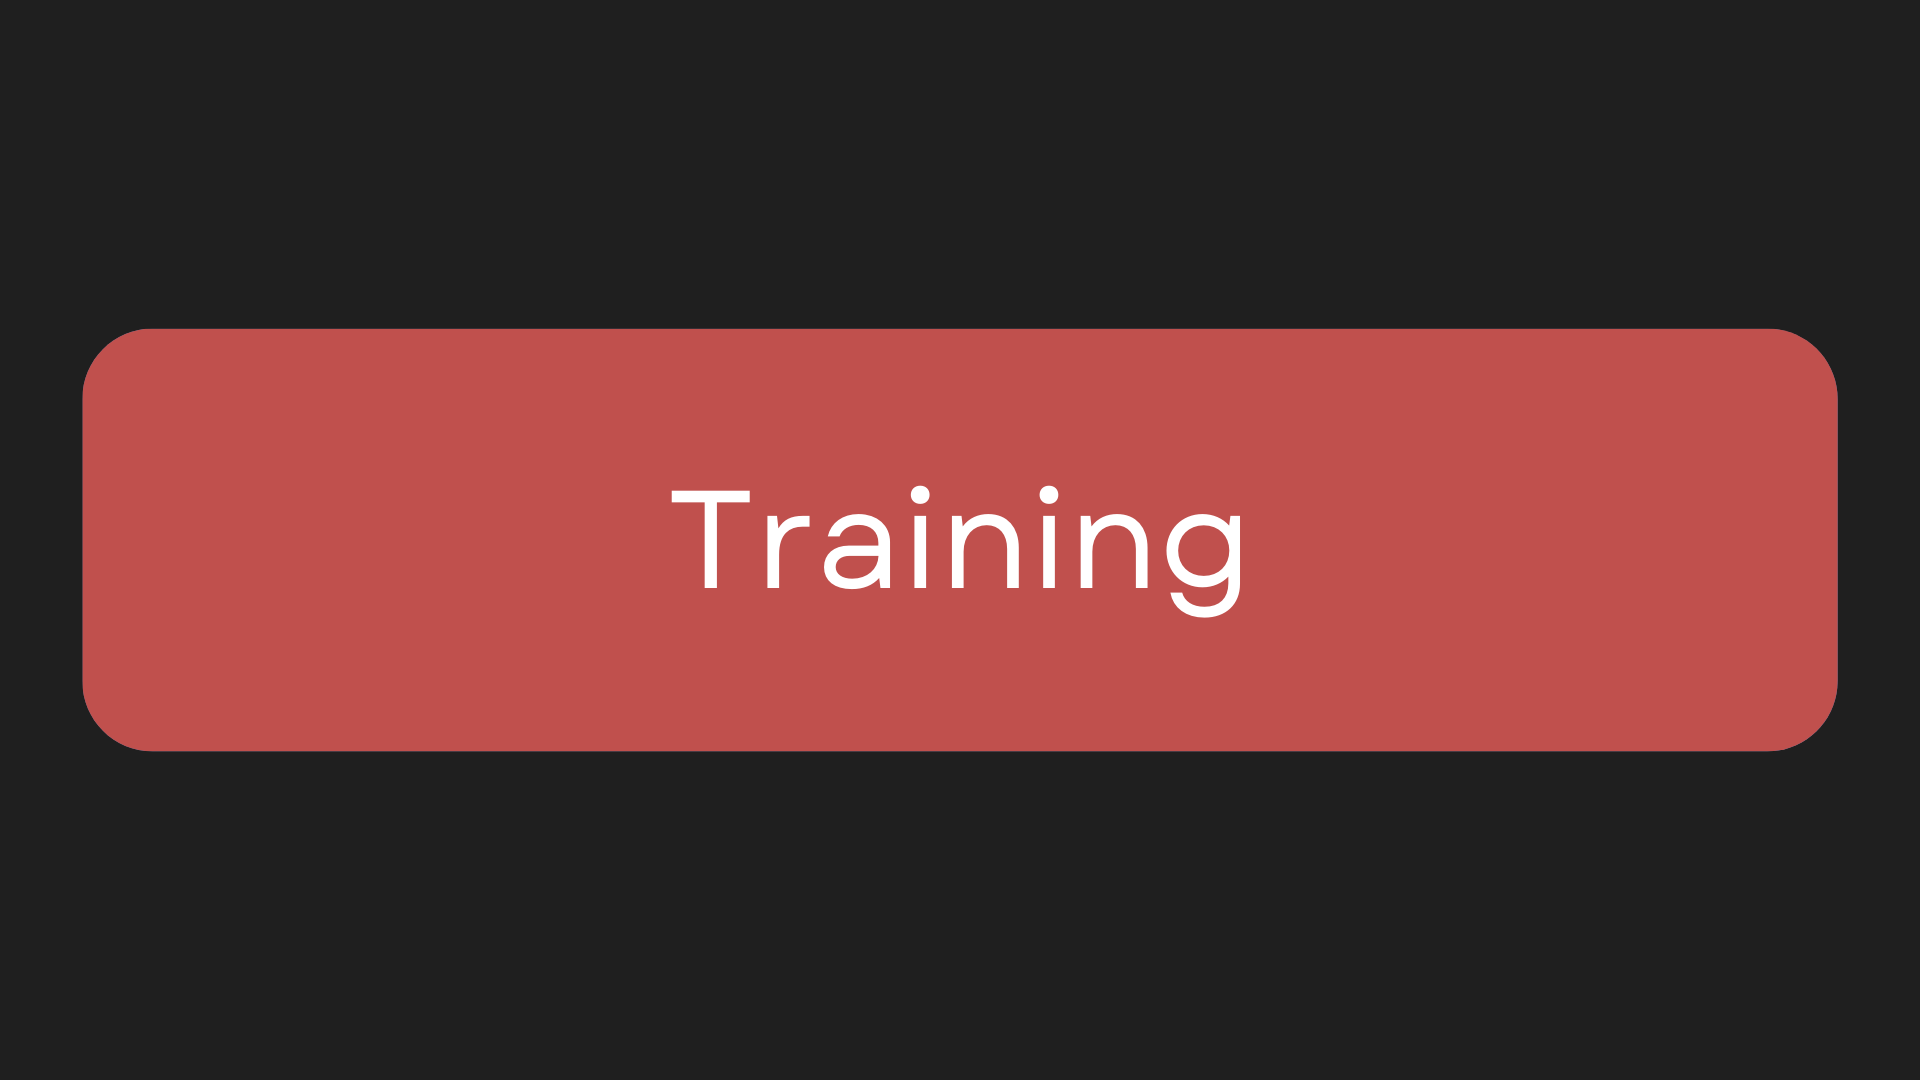

⌛For our training loop, you should:

1. Create a save directory for your model if it doesn't exist already using `os.makedirs(save_path, exist_ok=True)`
2. Move your model to your device (our Azure CPUs)
3. Create the training loop
    - `images` and `captions` as our input and output
    - Zero graidents
    - Forward pass
    - Reshape our outputs (because our outputs are formatted like [seq_len, batch_size, vocab_size] when we want them to be [seq_len * batch_size, vocab_size])
    - Calculate loss
    - Backward pass
    - Prevent exploding gradients with gradient clipping
    - Update weights (`optimizer.step()`) and progress (`num_batch`, `epoch_loss`)
    - Save checkpoints for each epoch and use the epoch with the smallest loss
4. Per epoch, calculate average loss
5. Using `plt`, plot the loss curve


In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm 
from torchvision import transforms
from model import CNN_to_LSTM
from preprocess import get_loader
import matplotlib.pyplot as plt
import os

def train_loop(model, dataloader, loss_fn, optimizer, epochs, device, vocab_size, save_path="checkpoints"):
    """
    Simple training loop for CNN-LSTM multimodal model
    
    Args:
        model: The CNN_to_LSTM model
        dataloader: DataLoader containing images and captions
        loss_fn: Loss function (CrossEntropyLoss)
        optimizer: Optimizer (Adam)
        epochs: Number of training epochs
        device: Device to train on (cuda or cpu)
        vocab_size: Size of vocabulary
        save_path: Path to save model checkpoints
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    # Track losses for plotting
    losses = []
    best_loss = float('inf')
    
    # Move model to device
    model.to(device)
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0
        
        for images, captions in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            captions = captions.to(device)            
            optimizer.zero_grad()
            
            # Forward pass
            # We need to provide both images and captions for teacher forcing
            outputs = model(images, captions[:-1])  # We don't need the EOS token for input
            
            # Calculate loss
            # The first sequence element in outputs corresponds to encoder features from the image
            # So we need to skip it and only use predictions that correspond to actual words
            
            # Skip the first prediction (from encoder features) and use the rest for loss
            # outputs shape: [seq_len, batch_size, vocab_size]
            outputs = outputs[1:, :, :]  # Skip the first sequence element (from image features)
            
            # Reshape outputs to [seq_length * batch_size, vocab_size]
            outputs = outputs.reshape(-1, vocab_size)
            
            # Get corresponding target captions starting from second token
            # This aligns with outputs starting from second prediction
            targets = captions[1:].reshape(-1)
            
            # Calculate loss
            loss = loss_fn(outputs, targets)
            
            loss.backward()
            
            # Apply gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_epoch_loss = epoch_loss / num_batches
        losses.append(avg_epoch_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}")
        
        # Save checkpoint after each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
        }, f"{save_path}/model_epoch_{epoch+1}.pt")
        
        # Save best model separately
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            torch.save(model, f"{save_path}/best_model.pt")
            print(f"New best model saved with loss: {best_loss:.4f}")
    
    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), losses, marker='o')
    plt.title('Training Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(f"{save_path}/training_loss.png")
    
    # Save final model
    torch.save(model, f"{save_path}/final_model.pt")
    
    return losses

Now it's time to combine all the steps:
  - 🟦Importing
  - 🟧Data Preprocessing
  - 🟩Multimodal AI Building
  - 🟥Training

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Get data loader and dataset
train_loader, dataset = get_loader(
    root_dir="data/images/", 
    captions_file="data/text.csv", 
    transform=transform,
    batch_size=32
)

# Print vocab size
vocab_size = len(dataset.vocab)
print(f"Vocabulary size: {vocab_size}")

# Initialize model
model = CNN_to_LSTM(
    embed_size=256,
    hidden_size=512,
    num_layers=2,
    vocab_size=vocab_size
)

# Define loss function and optimizer
# Ignore padding index (0) in loss calculation
loss_fn = nn.CrossEntropyLoss(ignore_index=dataset.vocab.word_to_index["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Train model
losses = train_loop(
    model=model,
    dataloader=train_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=50,
    device=device,
    vocab_size=vocab_size
)

print("Training completed!")
print(f"Final model saved to checkpoints/final_model.pt")

Using device: cpu
Vocabulary size: 5240


Epoch 1/50:   0%|          | 0/1265 [00:00<?, ?it/s]/anaconda/envs/azureml_py38/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/50:  16%|█▌        | 204/1265 [04:58<25:50,  1.46s/it]


KeyboardInterrupt: 